# Try false NN methods on chaotic system (coupled Rossler)
## Try with more variables / higher dimension observations

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
import embed_dynamics
# from sklearn.feature_selection import mutual_info_regression
# from scipy.stats import gaussian_kde
# from sklearn.neighbors import KernelDensity
# from sklearn.metrics import mutual_info_score
import sys, importlib
from dynamics_methods import *
from embedding_methods import *
# from scipy.stats import entropy
# from scipy.signal import argrelextrema
# from scipy.signal import find_peaks
from importlib import reload
%load_ext tensorboard

In [34]:
t0 = 0
t1 = 100 
dt = 0.01 
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]

init_list = [ None, np.array([0.1,0.2,0.3,0,0,15,-20])+np.random.randn(7)*0.2 ]
u_names = ['.']
pred=1

cross_sys = embed_dynamics.CoupledRosslerFullState(t0=t0, tf=t1, dt=dt, pred=pred, params=[0.925, 0.012])
sys_list = [cross_sys]
sys_names = ['Coupled Rossler full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
# A quick and dirty way to add another "test set" that uses longer time
for syst in sys_list:
    syst.add_u_func( u_func_list[0], init_list[0], (t0, t1*3, dt) )
for syst in sys_list:
    syst.data_generator()

u_names=['train0','test1','train_long']
out_names=['S1','S2','S3','S4','S5','S6','S7']

<Figure size 432x288 with 0 Axes>

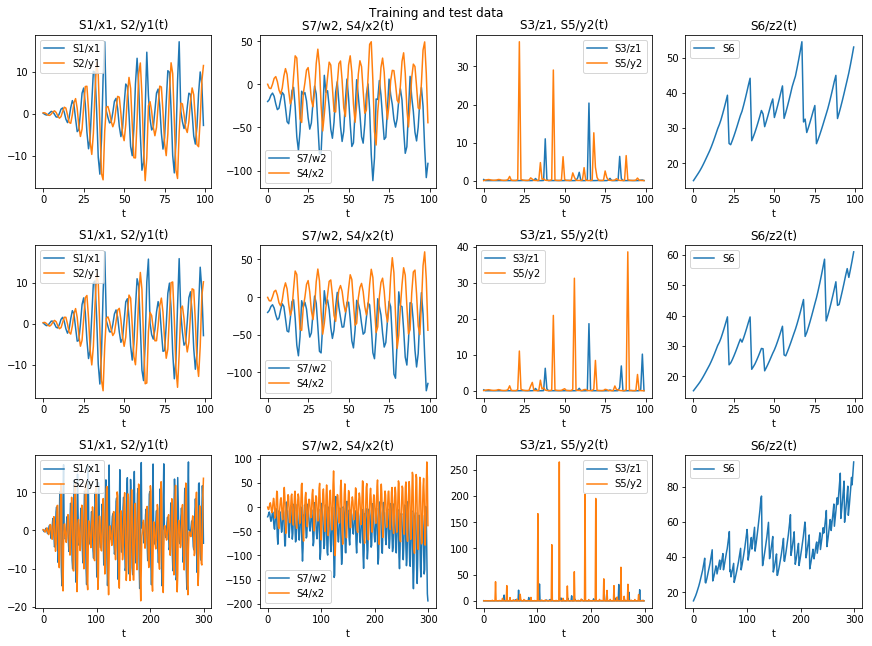

In [35]:
fig,axs = cross_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [231]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
# activation = 'tanh'
activation = 'sigmoid' # 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_masks = [ [4,7] ] # Reminder: index 0 is time. Index 1 is first state.
# input_masks = [ [7] ]
Nlayer = 2
Nneuron = 5

net_listF = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
#     sys_list[i].pred = 51
    net_listF.append(
        embed_dynamics.NN_FNN(
            sys_list[i], input_masks[i], ratio=10, stop_threshold=0, min_tau=100, max_tau=1000, max_de=10, verbose=True,
            fnn_ind=0, FNNtype='kennel', uniform_delay=False, inverse=True, 
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg
        )
    )
net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listF:
    nn.construct()


--- KNN (Kennel 1992) initializing itself ---
At delay = 100, the AMI is 1.2447013439207169.
At delay = 101, the AMI is 1.2391421058855032.
At delay = 102, the AMI is 1.2341435033195935.
At delay = 103, the AMI is 1.2299987714444134.
At delay = 104, the AMI is 1.2246537651029854.
At delay = 105, the AMI is 1.2206528427963699.
At delay = 106, the AMI is 1.2155577110935445.
At delay = 107, the AMI is 1.2118694586485441.
At delay = 108, the AMI is 1.2072182792904336.
At delay = 109, the AMI is 1.202966208804142.
At delay = 110, the AMI is 1.1981711879623536.
At delay = 111, the AMI is 1.1940537919708056.
At delay = 112, the AMI is 1.1900432210405079.
At delay = 113, the AMI is 1.1860317824526652.
At delay = 114, the AMI is 1.1826879023324004.
At delay = 115, the AMI is 1.1791291003463211.
At delay = 116, the AMI is 1.175510531605041.
At delay = 117, the AMI is 1.1734879859107021.
At delay = 118, the AMI is 1.1703728931996187.
At delay = 119, the AMI is 1.1670275963006853.
At delay = 120, 

In [232]:
# Train models. 
Epoch = 200
for nn in net_listF:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9808, 4, 1); outputset size = (9808, 7, 1)
Input set is masked by  [4, 7]
Train on 9808 samples
Epoch 1/200
9808/9808 [==============================] - 1s 109us/sample - loss: 1.4756
Epoch 2/200
9808/9808 [==============================] - 0s 32us/sample - loss: 0.7738
Epoch 3/200
9808/9808 [==============================] - 0s 35us/sample - loss: 0.6523
Epoch 4/200
9808/9808 [==============================] - 0s 35us/sample - loss: 0.5473
Epoch 5/200
9808/9808 [==============================] - 0s 36us/sample - loss: 0.4975
Epoch 6/200
9808/9808 [==============================] - 0s 30us/sample - loss: 0.4746
Epoch 7/200
9808/9808 [==============================] - 0s 32us/sample - loss: 0.4629
Epoch 8/200
9808/9808 [==============================] - 0s 30us/sample - loss: 0.4589
Epoch 9/200
9808/9808 [==============================] - 0s 30us/sample - loss: 0.4574
Epoch 10/200
9808/9808 [==============================] - 0s 32us/sample - loss: 0.4566
Epoch 11/200
98

In [479]:
# Plotting helper function...
# This one is modified to suite FNN. Don't remove it too soon. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title='', maxtime=None):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(15,Ncol*4),Nrow*3), squeeze=False)
#     figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
#             time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
#                 print(time_series)
#                 print(result.shape)
#                 print(n, i, n + len(net_inds)*i, j)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate, maxtime=maxtime
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
#                 axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
#         for i in range(Noutput):
#             axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
#             axst[i][j].legend(net_names)
            
    fig.suptitle(title)
#     figt.suptitle('Overlaying result for '+title)
    return fig, axs, results_list

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1, maxtime=None):
    if maxtime is None:
        maxtime = len(time)
    else:
        maxtime = int(maxtime)
    axs.plot(time[:maxtime:skip], data[:maxtime:skip])
#     print(time.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[:maxtime:skip], data2[:maxtime:skip])
        axs.legend(leglist)
    return axs

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

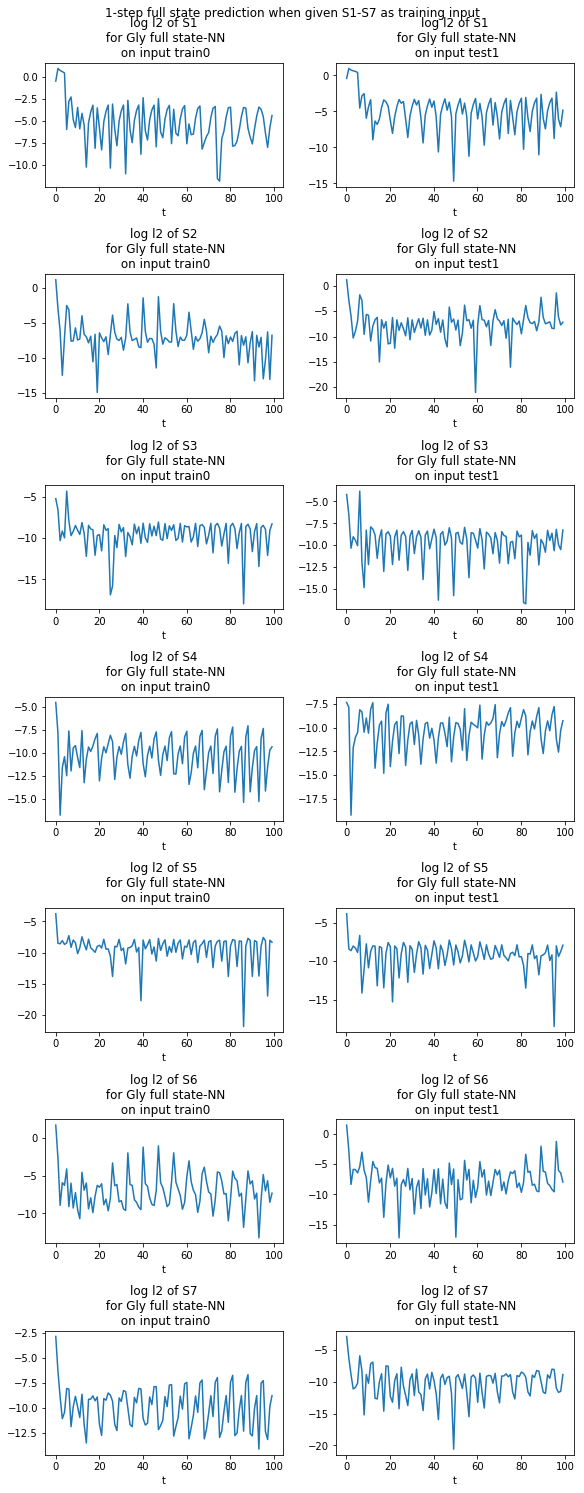

In [37]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S7 as training input\n' )

axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 10000).
The parameters have size (4,), so we resized the data into (2, 10000) for computation.
Turned data back to its original shape (2, 10000) and finishing the method.
axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 10000).
The parameters have size (4,), so we resized the data into (2, 10000) for computation.
Turned data back to its original shape (2, 10000) and finishing the method.
axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 30000).
The parameters have size (4,), so we resized the data into (2, 30000) for computation.
Turned data back to its original shape (2, 30000) and finishing the method.
Dimensions: Outputset = (9808, 7, 1), results = (9808, 7, 1)


<Figure size 432x288 with 0 Axes>

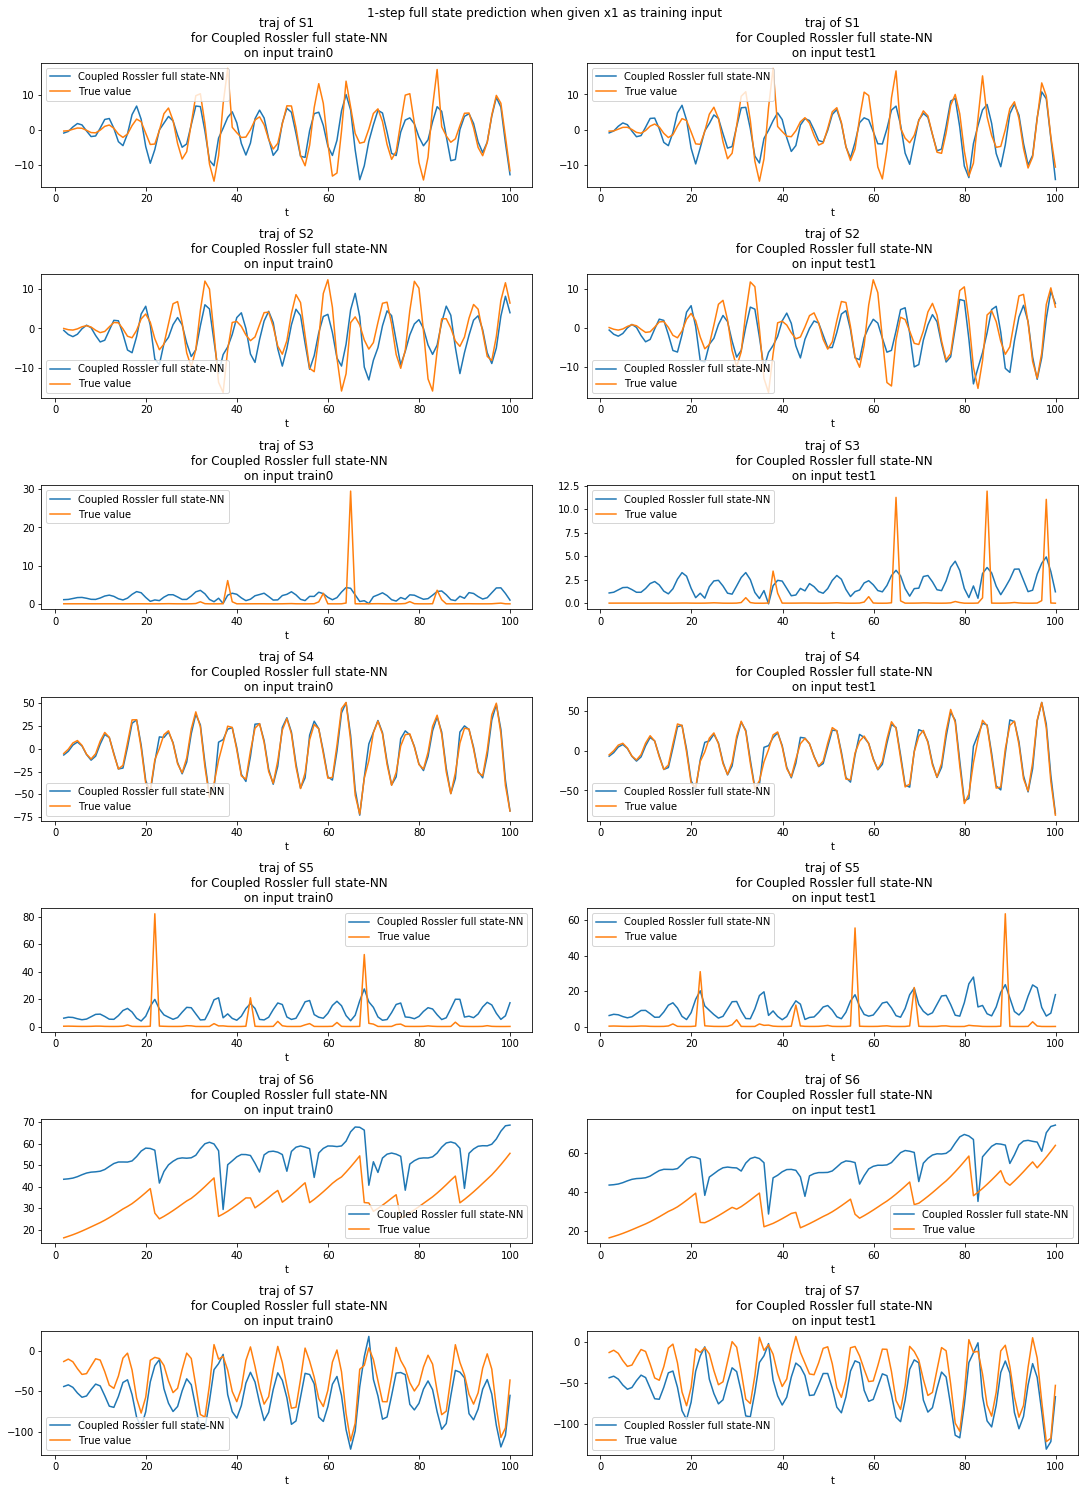

In [234]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, maxtime=20/dt
                       title='1-step full state prediction when given x1 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

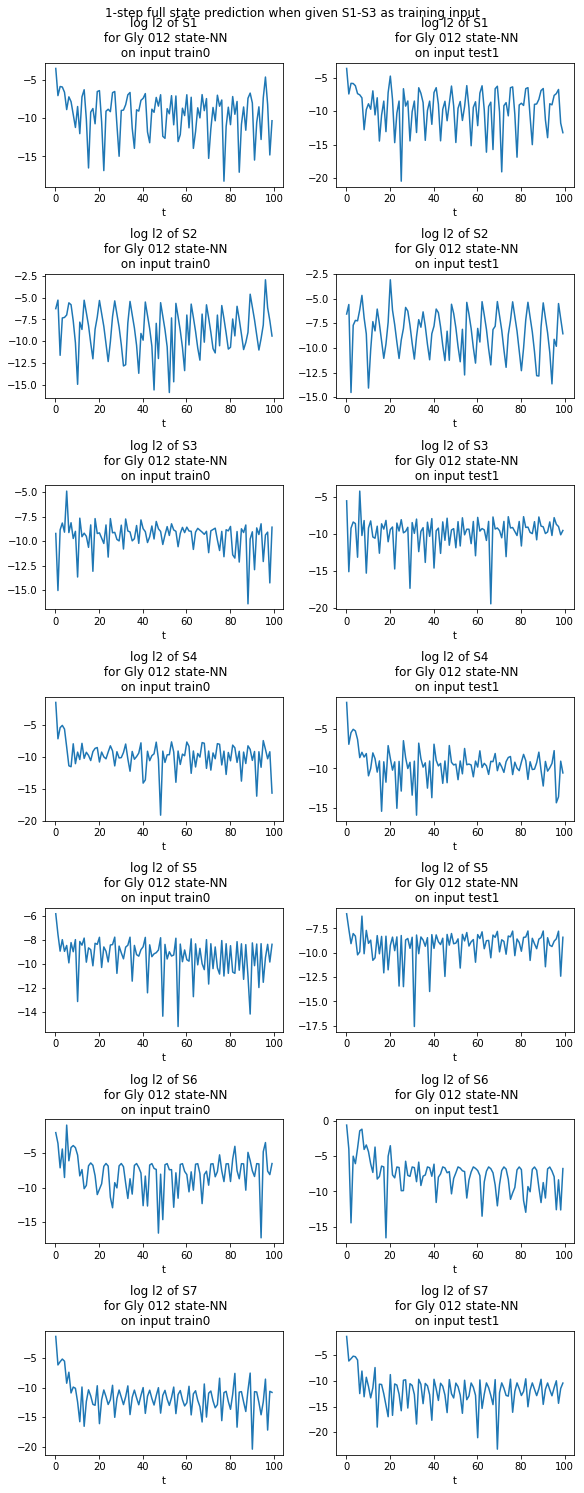

In [34]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

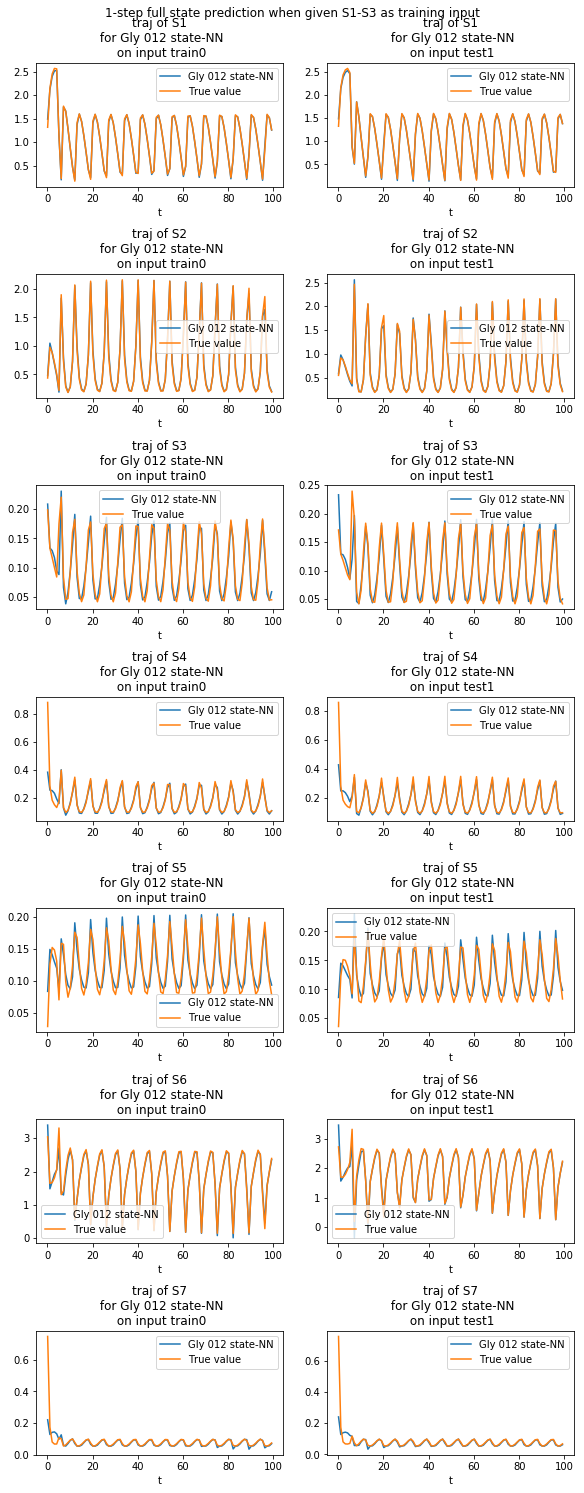

In [35]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 10000).
The parameters have size (4,), so we resized the data into (2, 10000) for computation.
Turned data back to its original shape (2, 10000) and finishing the method.
axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 10000).
The parameters have size (4,), so we resized the data into (2, 10000) for computation.
Turned data back to its original shape (2, 10000) and finishing the method.
axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 30000).
The parameters have size (4,), so we resized the data into (2, 30000) for computation.
Turned data back to its original shape (2, 30000) and finishing the method.
Dimensions: Outputset = (9808, 7, 1), results = (9808, 7, 1)


<Figure size 432x288 with 0 Axes>

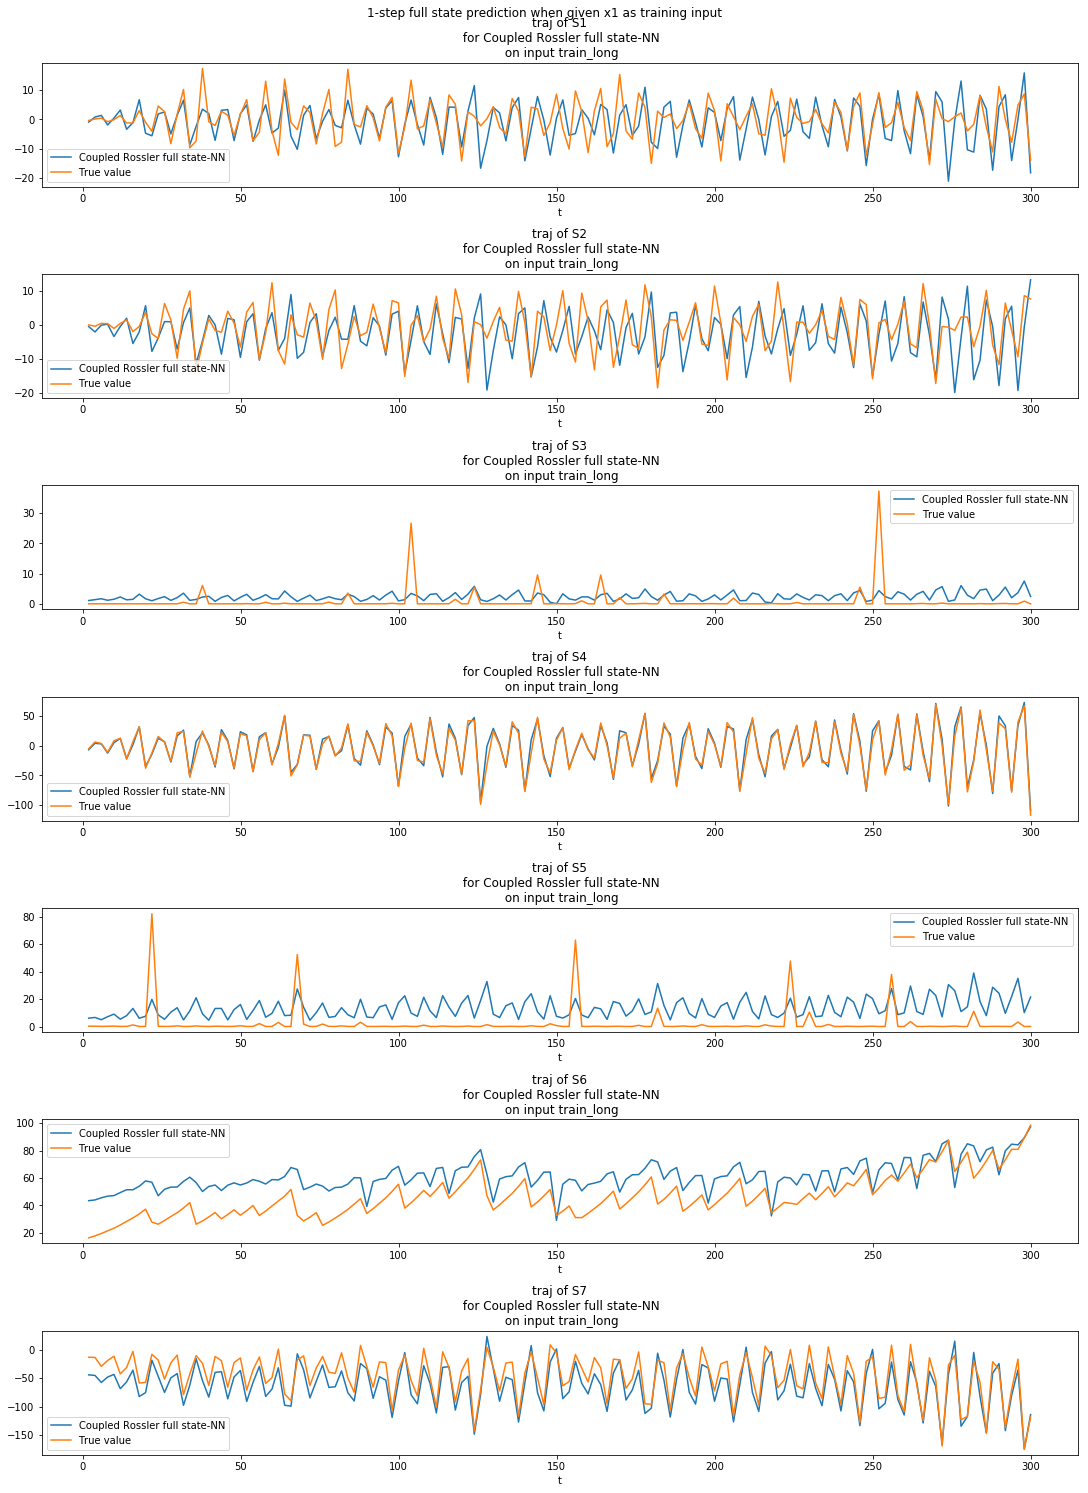

In [233]:
# Plots the test dataset with very long time range
fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=200, 
                       title='1-step full state prediction when given x1 as training input\n' )
# fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
#                        net_names=net_names, u_names=u_names, out_names=out_names,
#                        datatype='l2', log_mode=True, plot_skip_rate=500, 
#                        title='1-step full state prediction when given S1-S3 as training input\n' )

In [227]:
net_listF[0].output_norm_params

(array([  0.1523383 ,  -0.55295908,   0.60006776,  -2.45364499,
          2.63776663,  34.3975969 , -34.45840366]),
 array([ 6.26900395,  6.16864067,  3.59855455, 26.22618608, 14.07583831,
         8.01144445, 27.47511179]))

In [218]:
net_listF[0].Inputset[0].shape

(9803, 5, 1)

In [513]:
reload(networks)
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["dynamics_methods"])
from dynamics_methods import *
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *

# To be extra safe, run the reloading code for two times
reload(networks)
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["dynamics_methods"])
from dynamics_methods import *
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *

In [525]:
# Alternate code if you want to specify your own embeddings
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
# opt_args = (0.005,) # Order: (Learning rate,)
activation = 'tanh' # 'leaky relu 0.2' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_masks = [ [4,7] ] # Reminder: index 0 is time. Index 1 is first state.
# input_masks = [ [4] ]
# input_masks = [[1,4]]
# input_masks = [[1,4,7]]
Nlayer = 2 #3
Nneuron = 10 #20
# tts = np.array([[60,120,180,240,300,360,420,0]])
# tts = np.array([[10,30,60,100,150,0]])
# tts = np.array([[60,120,180,240,300,0],
#                 [60,120,180,240,300,0],
#                 [40,80,120,160,200,0]])
tts = np.array([[60,120,180,240,300,0],
                [60,120,180,240,300,0]])
# tts = np.array([[33,77,111,154,177,0],
#                 [44,77,110,154,199,0]])
js,ts = delay_embed_converter_Garcia_Cao(False, tts)
de = 6
delay_int = 60

pred = 50

net_listM = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listM.append(
        embed_dynamics.NN_FNN(
            sys_list[i], input_masks[i], ratio=10, stop_threshold=0, min_tau=100, max_tau=1000, max_de=10, verbose=True,
            fnn_ind=0, FNNtype='kennel', uniform_delay=False, inverse=True, 
            delay_vars=(js, ts, tts),
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, opt_args=opt_args, pred=pred
        ))
    net_listM.append(
        embed_dynamics.NN_Delay(
            sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, loss='mse', pred=pred, 
            de=de, delay_int=delay_int #, sym=True
        )
    )
# net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]
net_names = ['FNN','delay']

Epoch = 100
# Construct models
for nn in net_listM:
    nn.construct()
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9650, 12, 1); outputset size = (9650, 7, 1)
Input set is masked by  [4, 7]
Train on 9650 samples
Epoch 1/100
9650/9650 [==============================] - 1s 114us/sample - loss: 0.4890
Epoch 2/100
9650/9650 [==============================] - 0s 49us/sample - loss: 0.3889
Epoch 3/100
9650/9650 [==============================] - 0s 45us/sample - loss: 0.3690
Epoch 4/100
9650/9650 [==============================] - 0s 36us/sample - loss: 0.3581
Epoch 5/100
9650/9650 [==============================] - 0s 36us/sample - loss: 0.3458
Epoch 6/100
9650/9650 [==============================] - 0s 37us/sample - loss: 0.3338
Epoch 7/100
9650/9650 [==============================] - 0s 38us/sample - loss: 0.3234
Epoch 8/100
9650/9650 [==============================] - 0s 43us/sample - loss: 0.3197
Epoch 9/100
9650/9650 [==============================] - 0s 42us/sample - loss: 0.3101
Epoch 10/100
9650/9650 [==============================] - 0s 41us/sample - loss: 0.3053
Epoch 11/100
9

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  return data, params


Train on 9650 samples
Epoch 1/100
9650/9650 [==============================] - 1s 116us/sample - loss: 0.6854
Epoch 2/100
9650/9650 [==============================] - 0s 35us/sample - loss: 0.4612
Epoch 3/100
9650/9650 [==============================] - 0s 33us/sample - loss: 0.4301
Epoch 4/100
9650/9650 [==============================] - 0s 33us/sample - loss: 0.4126
Epoch 5/100
9650/9650 [==============================] - 0s 31us/sample - loss: 0.3998
Epoch 6/100
9650/9650 [==============================] - 0s 31us/sample - loss: 0.3898
Epoch 7/100
9650/9650 [==============================] - 0s 33us/sample - loss: 0.3822
Epoch 8/100
9650/9650 [==============================] - 0s 39us/sample - loss: 0.3760
Epoch 9/100
9650/9650 [==============================] - 0s 38us/sample - loss: 0.3709
Epoch 10/100
9650/9650 [==============================] - 0s 34us/sample - loss: 0.3668
Epoch 11/100
9650/9650 [==============================] - 0s 36us/sample - loss: 0.3633
Epoch 12/100
9650/

In [470]:
for nn in net_listM:
    nn.train(epoch=500, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Train on 9650 samples
Epoch 1/500
9650/9650 [==============================] - 0s 45us/sample - loss: 0.0818
Epoch 2/500
9650/9650 [==============================] - 0s 47us/sample - loss: 0.0817
Epoch 3/500
9650/9650 [==============================] - 0s 43us/sample - loss: 0.0806
Epoch 4/500
9650/9650 [==============================] - 0s 41us/sample - loss: 0.0809
Epoch 5/500
9650/9650 [==============================] - 0s 40us/sample - loss: 0.0812
Epoch 6/500
9650/9650 [==============================] - 0s 39us/sample - loss: 0.0814
Epoch 7/500
9650/9650 [==============================] - 0s 41us/sample - loss: 0.0815
Epoch 8/500
9650/9650 [==============================] - 0s 39us/sample - loss: 0.0811
Epoch 9/500
9650/9650 [==============================] - 0s 40us/sample - loss: 0.0807
Epoch 10/500
9650/9650 [==============================] - 0s 41us/sample - loss: 0.0816
Epoch 11/500
9650/9650 [==============================] - 0s 40us/sample - loss: 0.0809
Epoch 12/500
9650/9

In [412]:
net_listM[0].input_norm_params[0]

array([ 0.0627191 ,  0.12057046,  0.18222496,  0.22761257,  0.24013908,
        0.21180435, -2.39350546, -2.1789588 , -1.97034745, -1.80156447,
       -1.70327746, -1.69752152])

In [417]:
net_listM[0].Inputset[0].shape
net_listM[0].pred

51

Dimensions: Outputset = (9650, 7, 1), results = (9650, 7, 1)


<Figure size 432x288 with 0 Axes>

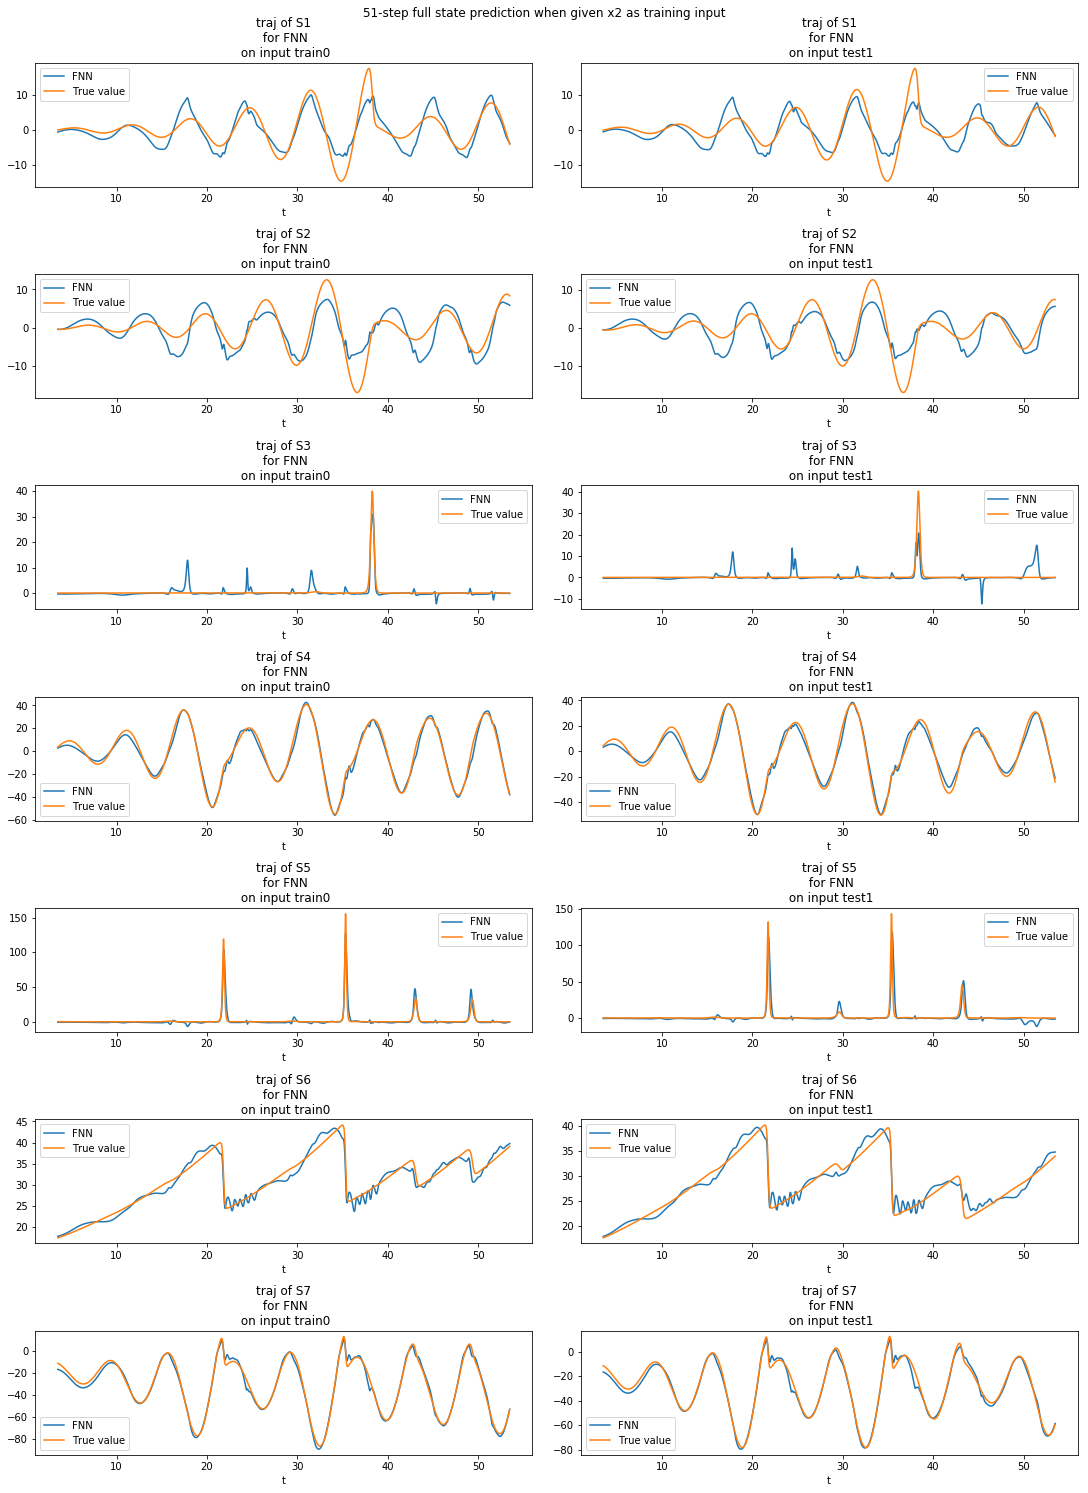

In [527]:
fig, axs, rlist = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=50/dt,
                       title='51-step full state prediction when given x2 as training input\n' )

Dimensions: Outputset = (9650, 7, 1), results = (9650, 7, 1)


/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  return data, params


<Figure size 432x288 with 0 Axes>

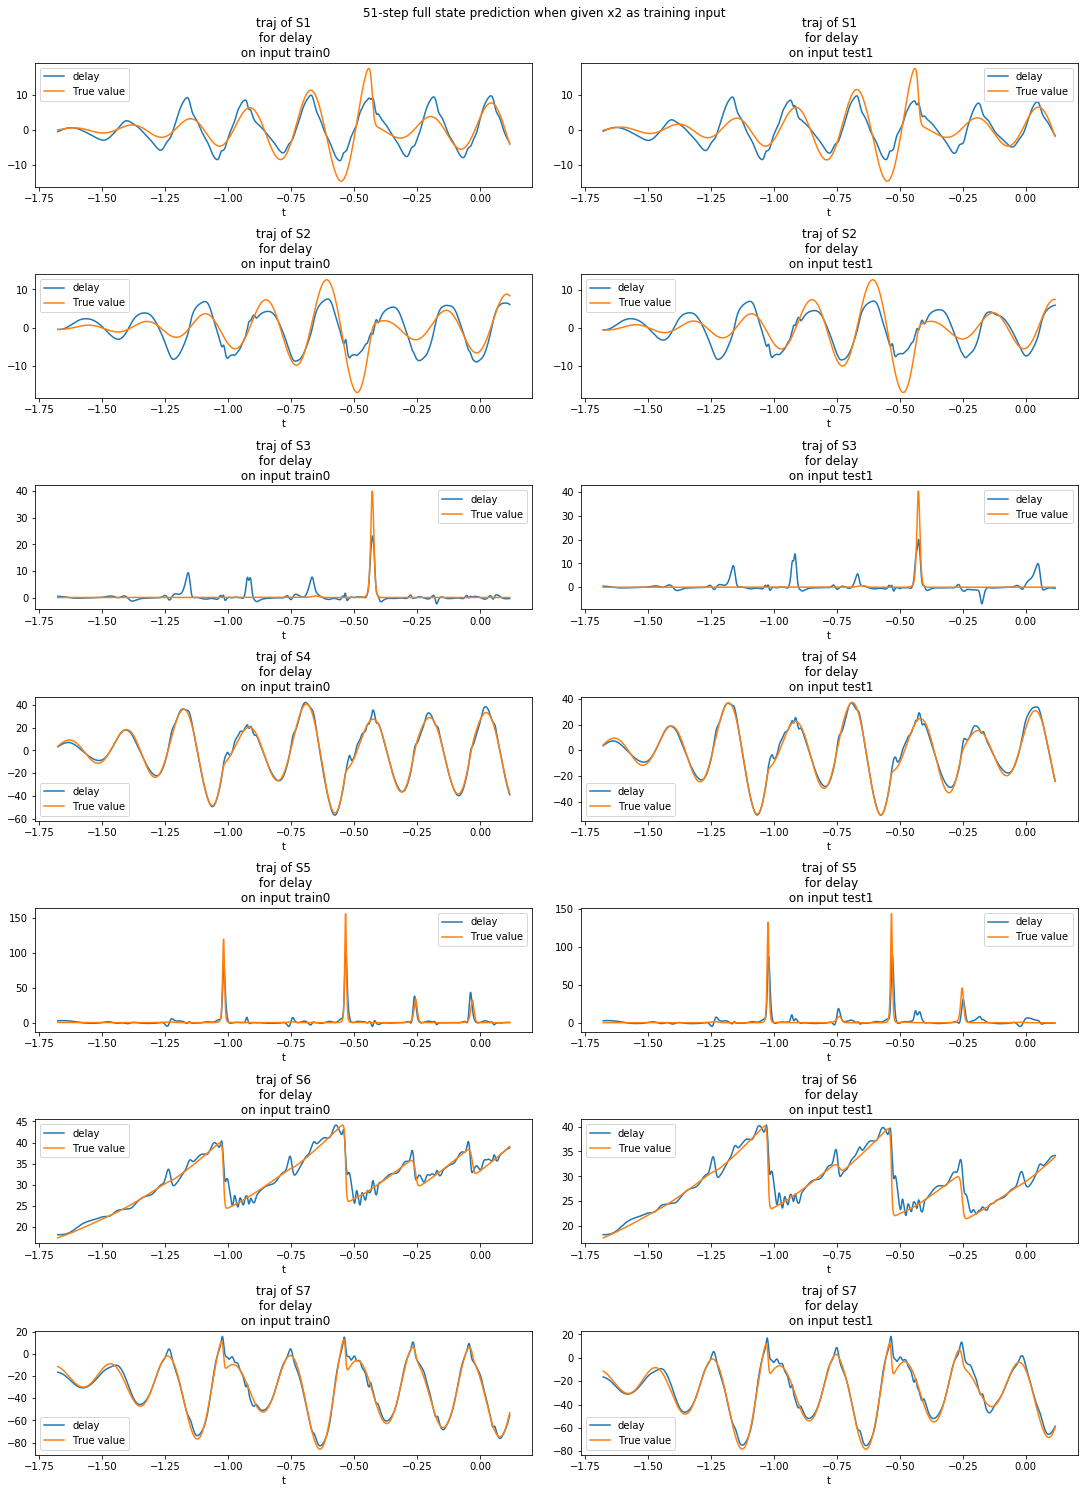

In [526]:
fig, axs, _ = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=50/dt,
                       title='51-step full state prediction when given x2 as training input\n' )

Dimensions: Outputset = (9650, 7, 1), results = (9650, 7, 1)


<Figure size 432x288 with 0 Axes>

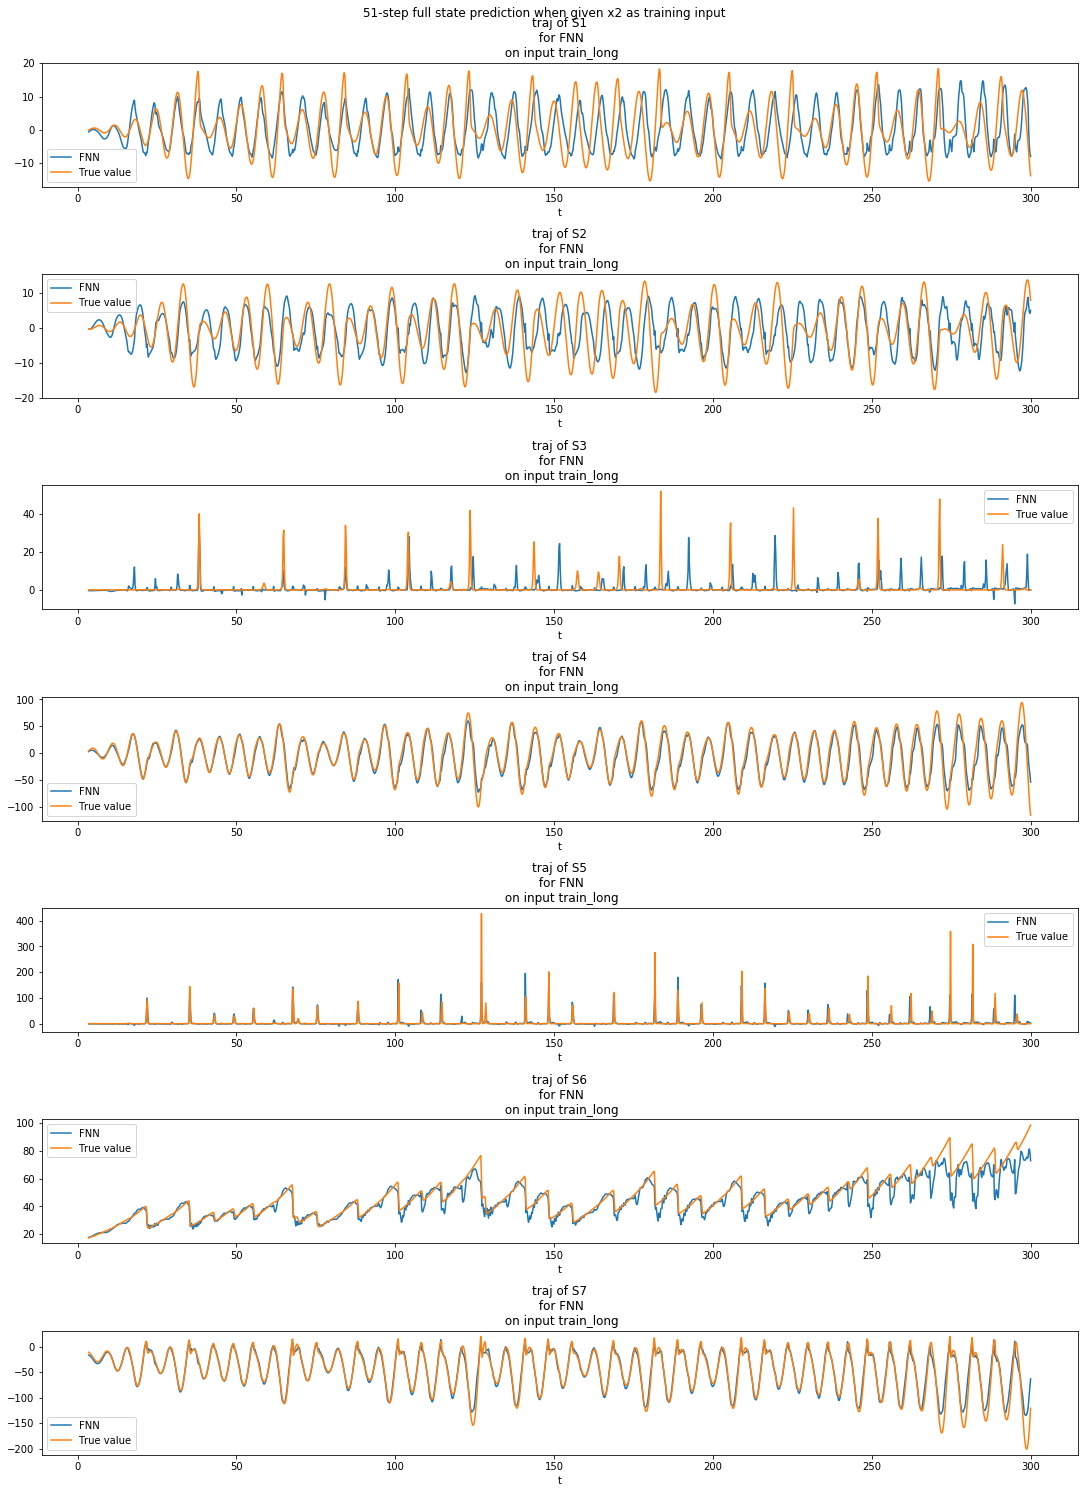

In [528]:
# Plots the test dataset with very long time range
fig, axs, _ = plot_tests( test_inds=[2], net_list=net_listM, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=20,
                       title='51-step full state prediction when given x2 as training input\n' )

In [502]:
rlist[0][0][0].shape, rlist[1][0][0].shape

((9690, 7, 1), (9690, 7, 1))

In [503]:
rlist[0][0][0][:,0,0], rlist[1][0][0][:,0,0]

(array([-1.8532952, -1.7837211, -1.7207696, ..., -6.427519 , -6.43828  ,
        -6.503023 ], dtype=float32),
 array([-1.6266459, -1.625321 , -1.6239012, ..., -7.2376676, -7.2376676,
        -7.237667 ], dtype=float32))

In [504]:
for j in range(7):
    print(np.linalg.norm( rlist[0][0][0][:,j,0] - rlist[1][0][0][:,j,0] ))

162.78583
239.14575
70.224205
1214.8606
363.29398
784.822
1374.675


In [524]:
for i in range(2):
    for j in range(6):
        print(np.linalg.norm( rlist[0][2][0][:,i*6+j,0] - rlist[1][2][0][:,i,j] ))

2.1797351714929616
1.0367490884811295
0.17680047389078835
0.9721233939720695
1.1550884537178565
0.9465346702375511
2.532687677245592
0.7581875439311255
0.6911080859522494
1.1321727896274245
0.8435286558221319
1.7857549892702327


IndexError: index 12 is out of bounds for axis 1 with size 12

In [508]:
net_listM[0].input_norm_params[0].reshape(3,6), net_listM[1].input_norm_params[0][[1,4,7]]

(array([[  0.10062962,   0.16229846,   0.21411106,   0.23801364,
           0.22303629,   0.16937869],
        [ -2.16857485,  -1.88260899,  -1.71719135,  -1.74862568,
          -1.99089129,  -2.38072594],
        [-32.43215971, -32.6735489 , -32.9876533 , -33.35286931,
         -33.73744008, -34.10369744]]),
 array([  0.18457796,  -1.98143635, -33.60888122]))

In [509]:
net_listM[0].input_norm_params[1].reshape(3,6), net_listM[1].input_norm_params[1][[1,4,7]]

(array([[ 6.15751057,  6.20596826,  6.23847336,  6.2453098 ,  6.2513731 ,
          6.29361227],
        [25.2376021 , 25.50617312, 25.58654467, 25.60677523, 25.82559112,
         26.29293526],
        [25.75117747, 25.9085119 , 26.20387402, 26.60285206, 27.01721798,
         27.34437232]]), array([ 6.23235677, 25.6790692 , 26.79457367]))

In [511]:
net_listM[0].output_norm_params[0], net_listM[1].output_norm_params[0]

(array([  0.157415  ,  -0.55690163,   0.6068389 ,  -2.4516766 ,
          2.66540009,  34.60313882, -34.73159041]),
 array([  0.157415  ,  -0.55690163,   0.6068389 ,  -2.4516766 ,
          2.66540009,  34.60313882, -34.73159041]))

In [512]:
net_listM[0].output_norm_params[1], net_listM[1].output_norm_params[1]

(array([ 6.3052712 ,  6.20438649,  3.61892653, 26.37800833, 14.15533324,
         7.82726252, 27.51730807]),
 array([ 6.3052712 ,  6.20438649,  3.61892653, 26.37800833, 14.15533324,
         7.82726252, 27.51730807]))

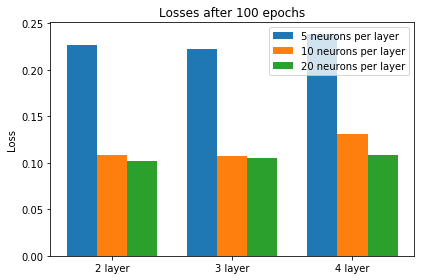

In [473]:
# Compare all the loss values from using NN_Delay with x1, x2 both observed.
labels = ['2 layer', '3 layer', '4 layer']
neu5loss100 = [0.227, 0.222, 0.2389] # From 2 layer to 4 layer
neu10loss100 = [0.1079, 0.1069, 0.1309]
neu20loss100 = [0.1018, 0.1056, 0.1080]
neu5loss500 = [0.1557, 0.1514, 0.2219]
neu10loss500 = [0.0701, 0.0798, 0.0920]
neu20loss500 = [0.065, 0.0697, 0.0818]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects5 = ax.bar(x - width, neu5loss100, width, label='5 neurons per layer')
rects10 = ax.bar(x, neu10loss100, width, label='10 neurons per layer')
rects20 = ax.bar(x + width, neu20loss100, width, label='20 neurons per layer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Losses after 100 epochs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

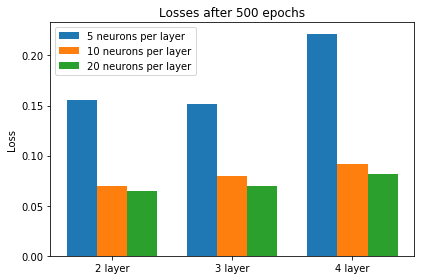

In [474]:
fig, ax = plt.subplots()
rects5 = ax.bar(x - width, neu5loss500, width, label='5 neurons per layer')
rects10 = ax.bar(x, neu10loss500, width, label='10 neurons per layer')
rects20 = ax.bar(x + width, neu20loss500, width, label='20 neurons per layer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Losses after 500 epochs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [351]:
# dir(net_listM[0].model.get_layer('dense'))
net_listM[0].model.get_layer('dense_1').activation

<function tensorflow.python.keras.activations.sigmoid(x)>

In [298]:
type(tf.keras.activations.relu)
type(tf.keras.layers.LeakyReLU(alpha=0.1))
# type(tf.keras.layers.Dense(1))
isinstance(tf.keras.layers.LeakyReLU(alpha=0.1),tf.keras.layers.Layer)

True

In [345]:
isinstance(tf.keras.layers.LeakyReLU,tf.keras.layers.Layer)
# dir(type(tf.keras.layers.LeakyReLU))
tf.keras.layers.LeakyReLU().__class__

tensorflow.python.keras.layers.advanced_activations.LeakyReLU

In [343]:
type(tf.keras.layers.LeakyReLU).__name__

'type'

In [346]:
a = (0.9,0.3,0.2)
type(a) is tuple
aa = (tf.keras.layers.LeakyReLU, 0.2)
isinstance(aa[0](),tf.keras.layers.Layer)

True

In [348]:
bbb = aa[0](*aa[1:])
bbb.alpha

array(0.2, dtype=float32)

In [337]:
bb = tf.keras.layers.LeakyReLU(*a[2:])

In [335]:
bb.alpha

array(0.2, dtype=float32)

In [370]:
def afunc(a=0,b=1,c=2,d=3,e=4):
    print(a,b,c,d,e)
afuncarg = () # <-- empty tuple
afunc(*afuncarg)

3 1 2 3 4


In [387]:
abcbc = type(tf.keras.optimizers.get('Adam'))(epsilon=0.11)
abcbc.epsilon

0.11

In [392]:
# isinstance(tf.keras.optimizers.get('Adam'), type)
isinstance(tf.keras.optimizers.Adam, type)

True

## Test embedding methods

In [107]:
importlib.reload(sys.modules["embedding_methods"])
importlib.reload(sys.modules["embed_dynamics"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
from embed_dynamics import *
X = cross_sys.Inputset[0][1:8]

In [81]:
# Single-variable MI methods to find their best delays
find_delay(X[0], method='mi', MImethod='KL total', min_delay=1, max_delay=700, max_dim=10, 
           end_early=True, verbose=False, pairwise=False, 
           uniform_delay=True, init_i=0, Nbin=50, ep=1e-10)

---Ending AMI/MMI local min now---


(159, True)

In [137]:
# Single-variable methods to find best delay dimension
for i in range(7):
    results = find_delay_by_FNN(X[[i]], method='kennel', ratio=10, pred=1, stop_threshold=0, 
                      min_tau=100, max_tau=7000, max_dim=10, uniform_delay=False, 
                      end_early=True, verbose=False,
                      inverse=True, local_max=False, twoD=False)
    print(results)

---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
We've exhausted the allowed dimension limit. Exiting now.
([0, 0], [0, 119, 121], array([[119, 121,   0,   0,   0,   0,   0,   0,   0,   0]]))


In [110]:
# Multi-variable methods to find best delay dimension
o = 3
for i in range(7):
    if i == o:
        continue
    results = find_delay_by_FNN(X[[o,i]], method='kennel', ratio=10, pred=51, stop_threshold=0, 
                      min_tau=100, max_tau=7000, max_dim=10, uniform_delay=False, 
                      end_early=True, verbose=False,
                      inverse=True, local_max=False, twoD=False)
    print(results)

---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
We've exhausted the allowed dimension limit. Exiting now.
([1, 0], [0, 159, 138], array([[138,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [159,   0,   0,   0,   0,   0,   0,   0,   0,   0]]))
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min 

In [37]:
# Briefly test out the FNN method.
find_delay_by_FNN_Garcia(X[[0,3]], ratio=10, pred=1, stop_threshold=0, min_tau=1, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True)

Starting the 1-th embedding cycle
At delay=-1 using j=0 for de=0: average d1 = 0.18722664668354094; average d2 = 0.18648164214222226
0 out of 9998 samples counted as false neighbors
At delay=-1 using j=1 for de=0: average d1 = 0.2474540307619737; average d2 = 0.24595182208796634
0 out of 9998 samples counted as false neighbors
At delay=-2 using j=0 for de=0: average d1 = 0.19388116338016895; average d2 = 0.19005009048352928
0 out of 9997 samples counted as false neighbors
At delay=-2 using j=1 for de=0: average d1 = 0.26174150806647184; average d2 = 0.25534543365735474
0 out of 9997 samples counted as false neighbors
At delay=-3 using j=0 for de=0: average d1 = 0.1990696674058772; average d2 = 0.19569026291540428
0 out of 9996 samples counted as false neighbors
At delay=-3 using j=1 for de=0: average d1 = 0.2707570995192026; average d2 = 0.26535360672216196
0 out of 9996 samples counted as false neighbors
At delay=-4 using j=0 for de=0: average d1 = 0.20294759320142491; average d2 = 0.

([], [], [])

Cao et al. 1998

In [67]:
find_delay_by_FNN_Cao( X[[0,3]], pred=1, min_tau=100, max_tau=700, max_dim=10, 
                              init_i=0, end_early=True, verbose=True )

--- KNN (Cao 1998) initializing itself ---
At delay = 100, the AMI is 1.8722479360695834.
At delay = 101, the AMI is 1.8702202601677484.
At delay = 102, the AMI is 1.8671303262516838.
At delay = 103, the AMI is 1.8635129832958715.
At delay = 104, the AMI is 1.8594762880585334.
At delay = 105, the AMI is 1.854016777783058.
At delay = 106, the AMI is 1.8471643728388774.
At delay = 107, the AMI is 1.8410590782200638.
At delay = 108, the AMI is 1.8364084255359856.
At delay = 109, the AMI is 1.8322062616754993.
At delay = 110, the AMI is 1.8279112971665121.
At delay = 111, the AMI is 1.8230862429570918.
At delay = 112, the AMI is 1.8183146545611075.
At delay = 113, the AMI is 1.813808494520682.
At delay = 114, the AMI is 1.8093336763512458.
At delay = 115, the AMI is 1.8055551710292086.
At delay = 116, the AMI is 1.801577212804741.
At delay = 117, the AMI is 1.7982789433896427.
At delay = 118, the AMI is 1.7947072043876888.
At delay = 119, the AMI is 1.7916885783272445.
At delay = 120, the 

([0], [0, 159], array([[159,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]))

Test out other non-FNN information-theory-related methods

In [59]:
# total correlation - this one can't run on full states, because the computation grows exponentially. 
# iterate_for_local_min(X[:4], method='KL', pairwise=False, end_early=False, verbose=True) <-- won't work
iterate_for_local_min(X[[0,3]], method='KL', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 5.562811483990516.
At delay = 2, the AMI is 5.54764622531849.
At delay = 3, the AMI is 5.523116768383609.
At delay = 4, the AMI is 5.490279469538275.
At delay = 5, the AMI is 5.450296980036784.
At delay = 6, the AMI is 5.404314086440729.
At delay = 7, the AMI is 5.353434354720502.
At delay = 8, the AMI is 5.298723379707743.
At delay = 9, the AMI is 5.241169076075467.
At delay = 10, the AMI is 5.181614199397161.
At delay = 11, the AMI is 5.120727381293389.
At delay = 12, the AMI is 5.059032952679287.
At delay = 13, the AMI is 4.996961332015655.
At delay = 14, the AMI is 4.934882132391851.
At delay = 15, the AMI is 4.8731094932041294.
At delay = 16, the AMI is 4.811880793114931.
At delay = 17, the AMI is 4.7513242676297285.
At delay = 18, the AMI is 4.6914684214895965.
At delay = 19, the AMI is 4.6323055227955.
At delay = 20, the AMI is 4.573865989834724.
---AMI/MMI didn't find a local minimum within 20 delays


(20, False)

In [98]:
# KL divergence - this one can't run on full states, because the computation grows exponentially. 
# This is different from the one above. This one treats X and delayed X as total, separate distributions.
# iterate_for_local_min(X[2:4], method='total divergence', pairwise=False, end_early=False, verbose=True) #<-- won't work
iterate_for_local_min(X[:4], max_iter=50, method='total divergence', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 7400.95969591008.
At delay = 2, the AMI is 7646.693350129048.
1 is the optimal delay it found.
At delay = 3, the AMI is 7810.49072604935.
1 is the optimal delay it found.
At delay = 4, the AMI is 7916.009230712002.
1 is the optimal delay it found.
At delay = 5, the AMI is 7982.550869083535.
1 is the optimal delay it found.
At delay = 6, the AMI is 8014.734157127564.
1 is the optimal delay it found.
At delay = 7, the AMI is 8020.047377212842.
1 is the optimal delay it found.
At delay = 8, the AMI is 8023.92458414709.
1 is the optimal delay it found.
At delay = 9, the AMI is 8029.138000487235.
1 is the optimal delay it found.
At delay = 10, the AMI is 8035.7161119354405.
1 is the optimal delay it found.
At delay = 11, the AMI is 8043.74611174388.
1 is the optimal delay it found.
At delay = 12, the AMI is 8053.350512546836.
1 is the optimal delay it found.
At delay = 13, the AMI is 8064.745792036801.
1 is the optimal delay it found.
At delay = 14, the AMI is 8078.

(1, True)

In [110]:
# interaction information - this one can't run on full states, because the computation grows exponentially. 
# I don't know if it'll even make sense to run this pairwisely, but here it goes...
iterate_for_local_min(X[2:6], method='interaction', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 81.93562032278018.
At delay = 2, the AMI is 85.84714630428755.
1 is the optimal delay it found.
At delay = 3, the AMI is 86.58523818756656.
1 is the optimal delay it found.
At delay = 4, the AMI is 87.21022341459096.
1 is the optimal delay it found.
At delay = 5, the AMI is 87.75960902465191.
1 is the optimal delay it found.
At delay = 6, the AMI is 88.1881203547498.
1 is the optimal delay it found.
At delay = 7, the AMI is 88.25386678550173.
1 is the optimal delay it found.
At delay = 8, the AMI is 88.25676554051363.
1 is the optimal delay it found.
At delay = 9, the AMI is 88.288981153313.
1 is the optimal delay it found.
At delay = 10, the AMI is 88.31847552546584.
1 is the optimal delay it found.
At delay = 11, the AMI is 88.33785852831387.
1 is the optimal delay it found.
At delay = 12, the AMI is 88.35930135333946.
1 is the optimal delay it found.
At delay = 13, the AMI is 88.39702322682048.
1 is the optimal delay it found.
At delay = 14, the AMI is 88.44

(1, True)

In [62]:
# Distance-to-Diagonal, non-pairwise (it doesn't make sense to use pairwise)
iterate_for_local_min(X[[0,3]], method='DD', max_iter=100, pairwise=False, end_early=False, verbose=True)

At delay = 1, the AMI is -0.6698160266871748.
At delay = 2, the AMI is -2.6793548320708154.
At delay = 3, the AMI is -6.02710257050883.
At delay = 4, the AMI is -10.709393020730488.
At delay = 5, the AMI is -16.720505845261396.
At delay = 6, the AMI is -24.052787874985782.
At delay = 7, the AMI is -32.69677627933456.
At delay = 8, the AMI is -42.64131111791245.
At delay = 9, the AMI is -53.873631691956625.
At delay = 10, the AMI is -66.37945559561177.
At delay = 11, the AMI is -80.14304196424314.
At delay = 12, the AMI is -95.14724176916963.
At delay = 13, the AMI is -111.37353855241587.
At delay = 14, the AMI is -128.80208301489867.
At delay = 15, the AMI is -147.41172456809346.
At delay = 16, the AMI is -167.18004248255767.
At delay = 17, the AMI is -188.08337872522802.
At delay = 18, the AMI is -210.0968740485586.
At delay = 19, the AMI is -233.19450841400658.
At delay = 20, the AMI is -257.34914641045935.
At delay = 21, the AMI is -282.53258801713366.
At delay = 22, the AMI is -308

(100, False)

In [63]:
# Average Displacement, non-pairwise (it doesn't make sense to use pairwise)
iterate_for_local_min(X[[0,3]], method='AD', max_iter=100, pairwise=False, end_early=False, verbose=True)

At delay = 1, the AMI is 2.186472643718121.
At delay = 2, the AMI is 4.37378465459328.
1 is the optimal delay it found.
At delay = 3, the AMI is 6.561373761634772.
1 is the optimal delay it found.
At delay = 4, the AMI is 8.748557532914363.
1 is the optimal delay it found.
At delay = 5, the AMI is 10.934551831213053.
1 is the optimal delay it found.
At delay = 6, the AMI is 13.118518678700122.
1 is the optimal delay it found.
At delay = 7, the AMI is 15.29960858520562.
1 is the optimal delay it found.
At delay = 8, the AMI is 17.476974847746018.
1 is the optimal delay it found.
At delay = 9, the AMI is 19.64978540036597.
1 is the optimal delay it found.
At delay = 10, the AMI is 21.817219711139085.
1 is the optimal delay it found.
At delay = 11, the AMI is 23.97847620661399.
1 is the optimal delay it found.
At delay = 12, the AMI is 26.13276555890725.
1 is the optimal delay it found.
At delay = 13, the AMI is 28.279318672104043.
1 is the optimal delay it found.
At delay = 14, the AMI i

(1, True)

In [134]:
# Garcia with 1D local minimum criterion
find_delay_by_FNN_Garcia(X, ratio=1.15, pred=1, stop_threshold=0, max_tau=30, max_dim=10,
                         init_i=0, end_early=True, verbose=True, inverse=False, twoD=False)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.00549200836413464; average d2 = 0.005510719535773712
105 out of 9968 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.005554402073790368; average d2 = 0.005590145396559451
202 out of 9968 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.00497337873546979; average d2 = 0.004971145244520707
0 out of 9968 samples counted as false neighbors
At delay=1 using j=3 for de=0: average d1 = 0.004986676367662435; average d2 = 0.004984659415266209
0 out of 9968 samples counted as false neighbors
At delay=1 using j=4 for de=0: average d1 = 0.004961302183558986; average d2 = 0.00495867234350822
0 out of 9968 samples counted as false neighbors
At delay=1 using j=5 for de=0: average d1 = 0.0058340755977996225; average d2 = 0.005920188323607222
257 out of 9968 samples counted as false neighbors
At delay=1 using j=6 for de=0: average d1 = 0.004964788589108723; av

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0.010533707865168539,
  0.016755292465134946,
  0.020770620108368453,
  0.02388359257400903,
  0.025592131674026495,
  0.027802870621298804,
  0.029712909054406746,
  0.03142254793695412,
  0.03293172690763052,
  0.033738327141279244])

In [48]:
# Garcia with 1D local MAXimum criterion
find_delay_by_FNN_Garcia(X[[0,3]], ratio=1.15, pred=1, stop_threshold=0, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True, local_max=True, inverse=False, twoD=False)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.1877903592147608; average d2 = 0.1980978858975014
1380 out of 9998 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.24746362728744356; average d2 = 0.2820536263645115
1878 out of 9998 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.19431201583048624; average d2 = 0.20159265082671868
1161 out of 9997 samples counted as false neighbors
At delay=2 using j=1 for de=0: average d1 = 0.2620835982731542; average d2 = 0.2754435374346363
1217 out of 9997 samples counted as false neighbors
At delay=3 using j=0 for de=0: average d1 = 0.1994006903504173; average d2 = 0.20481866617999167
905 out of 9996 samples counted as false neighbors
At delay=3 using j=1 for de=0: average d1 = 0.2711691686444017; average d2 = 0.27962187204082034
863 out of 9996 samples counted as false neighbors
At delay=4 using j=0 for de=0: average d1 = 0.20342943167514096; average d2

([1, 1, 0, 1, 0],
 [12, 4, 1, 2, 1],
 [0.0019024732151797336,
  0.0013022137633977762,
  0.00030054097375275494,
  0.0003006012024048096,
  0.0001002104419280489])

In [49]:
# Garcia with 1D local maximum and backwards embedding
find_delay_by_FNN_Garcia(X[[0,6]], ratio=1.02, pred=1, stop_threshold=0, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True, local_max=True, inverse=True, twoD=False)

Starting the 1-th embedding cycle
At delay=-1 using j=0 for de=0: average d1 = 0.20736418655025643; average d2 = 0.20664263129339097
1112 out of 9998 samples counted as false neighbors
At delay=-1 using j=1 for de=0: average d1 = 0.26449253445529514; average d2 = 0.2619442065124623
1810 out of 9998 samples counted as false neighbors
At delay=-2 using j=0 for de=0: average d1 = 0.21111425909136264; average d2 = 0.208798964686164
832 out of 9997 samples counted as false neighbors
At delay=-2 using j=1 for de=0: average d1 = 0.28358742210860594; average d2 = 0.27358951781830926
945 out of 9997 samples counted as false neighbors
At delay=-3 using j=0 for de=0: average d1 = 0.21462628887646945; average d2 = 0.21214898973165525
596 out of 9996 samples counted as false neighbors
At delay=-3 using j=1 for de=0: average d1 = 0.2979674490436058; average d2 = 0.2887369673932037
625 out of 9996 samples counted as false neighbors
At delay=-4 using j=0 for de=0: average d1 = 0.2176106009683497; aver

([1], [17], [0.01021839310759367])

In [53]:
importlib.reload(sys.modules["embedding_methods"])
importlib.reload(sys.modules["embed_dynamics"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
from embed_dynamics import *
X = cross_sys.Inputset[0][1:8]

In [56]:
# Kennel "original" method
find_delay_by_FNN_Kennel(X[[0,6]], ratio=1.01, pred=1, stop_threshold=0.001, min_tau=1, max_tau=200, max_dim=10, 
                         uniform_delay=False, init_i=0, end_early=True, inverse=True, verbose=True)

--- KNN (Kennel 1992) initializing itself ---
At delay = 1, the AMI is 4.756880817874918.
At delay = 2, the AMI is 4.074320831641973.
At delay = 3, the AMI is 3.7892486624929096.
At delay = 4, the AMI is 3.6145309690295178.
At delay = 5, the AMI is 3.489796470079162.
At delay = 6, the AMI is 3.3958902997452305.
At delay = 7, the AMI is 3.319330903134809.
At delay = 8, the AMI is 3.2527910999021783.
At delay = 9, the AMI is 3.189059116278764.
At delay = 10, the AMI is 3.1290350704378067.
At delay = 11, the AMI is 3.071523387208304.
At delay = 12, the AMI is 3.0177310127509207.
At delay = 13, the AMI is 2.967831397157079.
At delay = 14, the AMI is 2.9221214351903866.
At delay = 15, the AMI is 2.878147560573936.
At delay = 16, the AMI is 2.837244972422458.
At delay = 17, the AMI is 2.798428686411416.
At delay = 18, the AMI is 2.7629003233816842.
At delay = 19, the AMI is 2.7287014716951044.
At delay = 20, the AMI is 2.697518098034352.
At delay = 21, the AMI is 2.6687074831333293.
At delay

([0], [0, 159], array([[159,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]))